# Fraudulent Transactions Predictive Analysis 
#### Name: Prateek Chitpur 

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from imblearn import under_sampling

import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings("ignore")

# Data Preprocessing 

In [89]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The dataset is tested for null and duplicate values. There are no null values and redundant values in the dataset. 

In [91]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [92]:
# df.duplicated().sum()

The attribute 'step' is considered to check if there is any significant correlation between step attribute and fraudulant transaction. It is seen that there is no correlation between these two variables. Hence, variable step is dropped in further steps.

In [93]:
df[df['step']==212]['isFraud'].value_counts()

0    34007
1       40
Name: isFraud, dtype: int64

In [94]:
df[df['isFraud']==1]['step'].value_counts()

212    40
523    30
249    28
501    28
730    28
       ..
112     2
168     2
202     2
548     2
304     2
Name: step, Length: 741, dtype: int64

Also, 'nameDest' and 'nameOrig' are considered to find if there is any significant relation with the attribute 'isFraud'. However, there is no relation between them. The attribute 'isFlaggedFraud' contains only 0 values and does not find significance in fraud prediction, so it is dropped.

In [95]:
df[df['isFraud']==1]['nameDest'].value_counts()

C1837027614    2
C200064275     2
C1980653895    2
C105660024     2
C1193568854    2
              ..
C899185516     1
C2111326031    1
C684459901     1
C1438776235    1
C1922098798    1
Name: nameDest, Length: 8169, dtype: int64

In [96]:
df[df['isFraud']==1]['nameOrig'].value_counts()

C1483983582    1
C1498185758    1
C680864117     1
C1124206695    1
C1994097574    1
              ..
C1651626047    1
C1395405060    1
C109032105     1
C725816726     1
C98533918      1
Name: nameOrig, Length: 8213, dtype: int64

In [97]:
df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [98]:
vals = df[df['isFraud']==1]['amount'].tolist()

In [99]:
sum(df['amount'])/len(df['amount']),sum(vals)/len(vals)

(179861.90354912292, 1467967.299140387)

In [100]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

The attribute 'type' shows that there are only fraudulent transactions for the transaction types of 'CASH_OUT' and 'TRANSFER'.

In [101]:
df[df.isFraud==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

# Exploratory Analysis 

The bar plot shows the count of different types of transaction types.

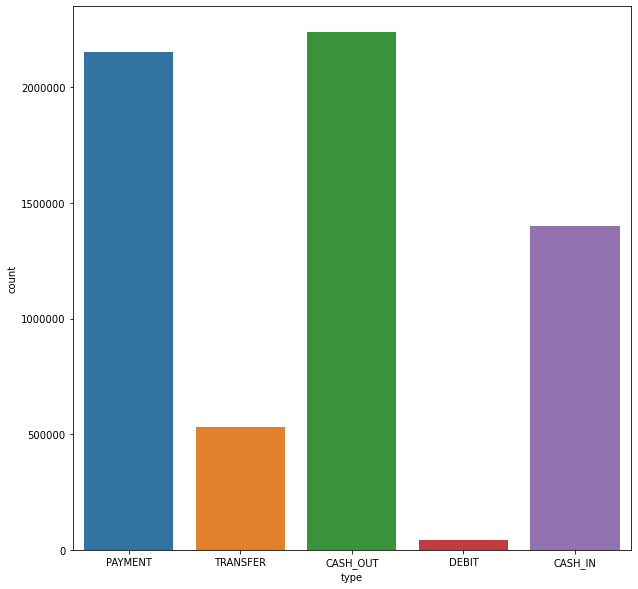

In [102]:
plt.figure(figsize=(10,10))
sns.countplot(x='type', data=df)
plt.ticklabel_format(style='plain', axis='y')

The below violin plot shows that the frequency of fraudulent transaction is maximum when the amount is 0.

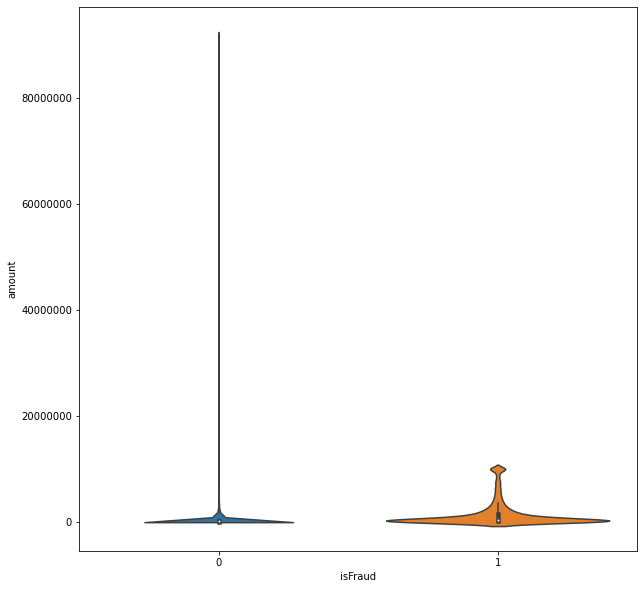

In [103]:
plt.figure(figsize=(10,10))
sns.violinplot(x=df['isFraud'], y=df['amount'], data=df)
plt.ticklabel_format(style='plain', axis='y')

In [104]:
df = df[df['type'].isin(['CASH_OUT','TRANSFER'])]

In [105]:
sum(df['amount'])/len(df['amount']),sum(vals)/len(vals)

(317536.14086859353, 1467967.299140387)

In [106]:
df[df['amount']==df['oldbalanceOrg']]['isFraud'].value_counts()

1    8034
Name: isFraud, dtype: int64

The fraudulent transactions are observed only in CASH_OUT and TRANSFER type. Hence, records of other types are eliminated in order to reduce noise in the dataset for building prediction model.

An important find is that the for all frauds, the amount column is equal to the oldbalanceOrg column so we would practically never need to develop a classification algorithm and could just use a normal conditional predictor. This can probably be a mistake with the dataset so would ignore it but just confirming with results

In [107]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [108]:
df.drop(['type'], axis = 1, inplace=True)

In [109]:
df.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [110]:
X = df.loc[:, df.columns != 'isFraud']
y = df['isFraud']

An important find is that the for all frauds, the amount column is equal to the oldbalanceOrg column for all cases having fraud so we would practically never need to develop a classification algorithm and could just use a normal conditional predictor. This can probably be a mistake with the dataset so would ignore it but just confirming with results

Correlation DataFrame

In [111]:
rs = np.random.RandomState(0)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.120389,0.018296,0.307133,0.497027,0.070660
oldbalanceOrg,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.347582
newbalanceOrig,0.018296,0.778826,1.000000,-0.012277,-0.015439,0.063557
oldbalanceDest,0.307133,-0.020403,-0.012277,1.000000,0.970060,-0.014960
newbalanceDest,0.497027,-0.010029,-0.015439,0.970060,1.000000,-0.008978
isFraud,0.070660,0.347582,0.063557,-0.014960,-0.008978,1.000000


Below is a correlation plot, which shows how the attributes are correlated with respect to the predictor variable 'isFraud'. The higher the value, the higher the correlation between the attributes.

<AxesSubplot:>

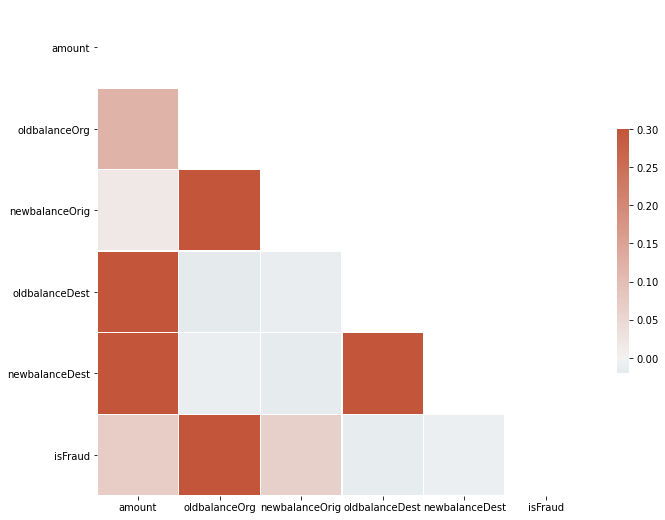

In [112]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [113]:
dict(df['isFraud'].value_counts())

{0: 2762196, 1: 8213}

The bar plot shows the total count of fraudulent and non-fraudulent transactions.

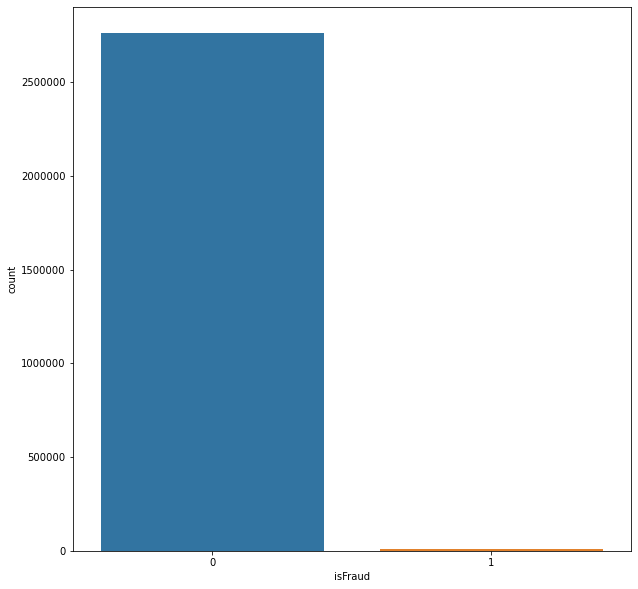

In [114]:
plt.figure(figsize=(10,10))
sns.countplot(x='isFraud', data=df)
plt.ticklabel_format(style='plain', axis='y')

# Model Development 

In [115]:
fraud_counts = y.value_counts()[1]
rus = under_sampling.RandomUnderSampler(
    sampling_strategy={
        0: fraud_counts * 5,
        1: fraud_counts
    },
    random_state=42
)
X,y = rus.fit_resample(X, y)

The dataset is split into 80% and 20% for train and test set.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, stratify=y, random_state = 0)

Three models Logisitc Regression, Random Forest and GradientBoosting Classifier are built to predict if the transaction if fraudulent or not.

In [117]:
models = []

models.append(("LogisticRegression", LogisticRegression(random_state = 42)))
models.append(("RandomForest", RandomForestClassifier(n_jobs = -1, random_state = 42)))
models.append(("GradientBoostingClassifier", GradientBoostingClassifier(random_state = 42)))

In [118]:
results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=2)
    names.append(name)
    print(name)
    print()
    print(result)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression

[0.9569276  0.95408655]
RandomForest

[0.98853432 0.98949825]
GradientBoostingClassifier

[0.98224342 0.9858962 ]
LogisticRegression 0.9555070772665009
RandomForest 0.9890162853229161
GradientBoostingClassifier 0.9840698087362387


In [119]:
from sklearn.metrics import classification_report, confusion_matrix

In [120]:
for name,model in models:
    classifier = model.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    print(classification_report(y_test,pred))
    print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8213
           1       0.83      0.93      0.88      1643

    accuracy                           0.96      9856
   macro avg       0.91      0.95      0.93      9856
weighted avg       0.96      0.96      0.96      9856

[[7906  307]
 [ 114 1529]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8213
           1       0.97      0.98      0.98      1643

    accuracy                           0.99      9856
   macro avg       0.98      0.99      0.99      9856
weighted avg       0.99      0.99      0.99      9856

[[8168   45]
 [  36 1607]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8213
           1       0.96      0.96      0.96      1643

    accuracy                           0.99      9856
   macro avg       0.97      0.97      0.97      9856
weighted avg       0

In [121]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_estimators = [int(x) for x in range(200,1000,100)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100, 500, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf
              }
print(random_grid)


{'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900], 'max_depth': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [122]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [100, 144, 188, 233, 277,
                                                      322, 366, 411, 455, 500,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900]},
                   random_state=42, verbose=2)

In [123]:
classifier = rf_random.best_estimator_.fit(X_train,y_train)
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8213
           1       0.97      0.98      0.98      1643

    accuracy                           0.99      9856
   macro avg       0.98      0.99      0.99      9856
weighted avg       0.99      0.99      0.99      9856

[[8166   47]
 [  30 1613]]


In [124]:
classifier = RandomForestClassifier(random_state=42).fit(X_train,y_train)
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8213
           1       0.97      0.98      0.98      1643

    accuracy                           0.99      9856
   macro avg       0.98      0.99      0.99      9856
weighted avg       0.99      0.99      0.99      9856

[[8168   45]
 [  36 1607]]


In [125]:
n_estimators = [int(x) for x in range(400,700,100)]

random_grid = {'n_estimators': n_estimators,
              }
print(random_grid)

{'n_estimators': [400, 500, 600]}


In [126]:
gb = GradientBoostingClassifier(random_state=42)
gb_random = GridSearchCV(estimator = gb, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   34.9s remaining:   43.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   52.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   52.0s finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [400, 500, 600]},
             verbose=2)

In [33]:
classifier = gb_random.best_estimator_.fit(X_train,y_train)
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8213
           1       0.97      0.99      0.98      1643

    accuracy                           0.99      9856
   macro avg       0.98      0.99      0.99      9856
weighted avg       0.99      0.99      0.99      9856

[[8154   59]
 [  13 1630]]


In [34]:
classifier = GradientBoostingClassifier(random_state=42, n_estimators=400).fit(X_train,y_train)
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8213
           1       0.96      0.99      0.98      1643

    accuracy                           0.99      9856
   macro avg       0.98      0.99      0.99      9856
weighted avg       0.99      0.99      0.99      9856

[[8152   61]
 [  12 1631]]


In [83]:
indices = np.where(y_test.values!=pred)[0]

In [96]:
mistakes = X_test.iloc[indices]

Hyperparameter tuning is preformed on random forest and gradient boosting models. The results are comparable.

If there was more time available, then I could have tried more models and evaluated the mistakes that the models are making. Also, I could have tried oversampling with SMOTE but due to time and processor constraint undersamplig is performed. Although, the results are better.